# 3. PRE-PROCESSING DATA
---

In [1]:
import warnings
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import pydotplus
import graphviz
from six import StringIO
from sklearn import preprocessing
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    ShuffleSplit,
    cross_val_score,
    cross_val_predict
)
from sklearn import model_selection
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from sklearn.inspection import permutation_importance
import smote_variants as sv

# Konfigurasi
seed = 42
pd.options.display.max_columns = None 
sns.set_palette("Set1")
sns.set_style("whitegrid")

## 3.1 Import Data

In [2]:
data_pre = pd.read_csv("C:/Users/ACER/OneDrive/Kuliah/SEM 8/Komputasi Statistika II/Project UAS/WA_Fn-UseC_-Telco-Customer-Churn.csv")
data_pre.set_index('customerID', inplace = True) # set customerID as index
data_pre.head() # show first 5 lines

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print('Dataset ini memiliki', data_pre.shape[0], 'baris (customer) dan', data_pre.shape[1], 'variables')

Dataset ini memiliki 7043 baris (customer) dan 20 variables


## 3.2 Replace missing values

In [4]:
data_pre.replace(r'^\s*$', np.nan, regex=True, inplace = True) # mengganti cell yang blank menjadi nan

In [5]:
# Menampilkan persentase missing values (NaN) untuk setiap kolom di data
df_null = data_pre.isnull().mean(axis = 0) # Menghitung rata-rata nilai NaN per kolom
df_null = df_null[df_null > 0] * 100 # Filter hanya kolom yang memiliki nilai NaN, dan konversi ke persen
print("Missing values columns: \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Missing values columns: 

TotalCharges    0.156183
dtype: float64



In [6]:
data_pre.TotalCharges.fillna(0, inplace = True)
data_pre = data_pre.astype({'TotalCharges': 'float64'}) # Ubah tipe data TotalCharges ke float

C:\Users\ACER\AppData\Local\Temp\ipykernel_25320\1742152594.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_pre.TotalCharges.fillna(0, inplace = True)


Hanya variabel Total Charges yang memiliki missing value sebanyak 11 customer dan semuanya tidak berhenti berlangganan (Churn = No). Terlihat juga 11 customer tersebut baru memiliki tenure 0 bulan. Hal ini cukup masuk akal karena pelanggan yang belum dikenakan tagihan akan memiliki Total Charges sebesar nol. Oleh karena itu, missung value akan diganti dengan nol.

## 3.3 Encoding Variabel

In [7]:
# Encoding variabel dependen
data_pre['Churn'] = data_pre['Churn'].map({'Yes': 1, 'No': 0})

In [8]:
# Encoding variabel independen yang kategorik
categorical_cols = data_pre.select_dtypes(include=['object']).columns


In [9]:
categorical_cols

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [10]:
# Daftar kolom yang ingin dicek
columns_to_check = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod']

# Loop untuk menampilkan unique values setiap kolom
for col in columns_to_check:
    print(f"\nUnique values in '{col}':")
    print(data_pre[col].unique())



Unique values in 'gender':
['Female' 'Male']

Unique values in 'Partner':
['Yes' 'No']

Unique values in 'Dependents':
['No' 'Yes']

Unique values in 'PhoneService':
['No' 'Yes']

Unique values in 'MultipleLines':
['No phone service' 'No' 'Yes']

Unique values in 'InternetService':
['DSL' 'Fiber optic' 'No']

Unique values in 'OnlineSecurity':
['No' 'Yes' 'No internet service']

Unique values in 'OnlineBackup':
['Yes' 'No' 'No internet service']

Unique values in 'DeviceProtection':
['No' 'Yes' 'No internet service']

Unique values in 'TechSupport':
['No' 'Yes' 'No internet service']

Unique values in 'StreamingTV':
['No' 'Yes' 'No internet service']

Unique values in 'StreamingMovies':
['No' 'Yes' 'No internet service']

Unique values in 'Contract':
['Month-to-month' 'One year' 'Two year']

Unique values in 'PaperlessBilling':
['Yes' 'No']

Unique values in 'PaymentMethod':
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [11]:
# Binary mapping (benar)
data_pre['Male'] = data_pre.gender.map({'Male': 1, 'Female': 0})
del data_pre['gender']

data_pre['Partner'] = data_pre.Partner.map({'No': 0, 'Yes': 1})
data_pre['Dependents'] = data_pre.Dependents.map({'No': 0, 'Yes': 1})
data_pre['PhoneService'] = data_pre.PhoneService.map({'No': 0, 'Yes': 1})
data_pre['MultipleLines'] = data_pre.MultipleLines.map({'No': 0, 'No phone service': 0, 'Yes': 1})
data_pre['OnlineSecurity'] = data_pre.OnlineSecurity.map({'No': 0, 'No internet service': 0, 'Yes': 1})
data_pre['OnlineBackup'] = data_pre.OnlineBackup.map({'No': 0, 'No internet service': 0, 'Yes': 1})
data_pre['DeviceProtection'] = data_pre.DeviceProtection.map({'No': 0, 'No internet service': 0, 'Yes': 1})
data_pre['TechSupport'] = data_pre.TechSupport.map({'No': 0, 'No internet service': 0, 'Yes': 1})
data_pre['StreamingTV'] = data_pre.StreamingTV.map({'No': 0, 'No internet service': 0, 'Yes': 1})
data_pre['StreamingMovies'] = data_pre.StreamingMovies.map({'No': 0, 'No internet service': 0, 'Yes': 1})
data_pre['PaperlessBilling'] = data_pre.PaperlessBilling.map({'No': 0, 'Yes': 1})

# One-hot encoding dengan konversi boolean ke 1/0
internet_dummies = pd.get_dummies(data_pre['InternetService'], prefix='InternetService').astype(int)
contract_dummies = pd.get_dummies(data_pre['Contract'], prefix='Contract').astype(int)
payment_dummies = pd.get_dummies(data_pre['PaymentMethod'], prefix='PaymentMethod').astype(int)

# Drop kolom asli & gabungkan kembali hasil encoding
data_pre.drop(columns=['InternetService', 'Contract', 'PaymentMethod'], inplace=True)
data_pre = pd.concat([data_pre, internet_dummies, contract_dummies, payment_dummies], axis=1)
data_pre.drop(columns='InternetService_No', inplace=True)

In [12]:
data_pre

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Male,InternetService_DSL,InternetService_Fiber optic,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,1,0,1,0,0,0,0,1,0
5575-GNVDE,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,1,0,0,1,0,0,0,0,1
3668-QPYBK,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,1,1,0,1,0,0,0,0,0,1
7795-CFOCW,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,1,0,0,1,0,1,0,0,0
9237-HQITU,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,0,1,1,24,1,1,1,0,1,1,1,1,1,84.80,1990.50,0,1,1,0,0,1,0,0,0,0,1
2234-XADUH,0,1,1,72,1,1,0,1,1,0,1,1,1,103.20,7362.90,0,0,0,1,0,1,0,0,1,0,0
4801-JZAZL,0,1,1,11,0,0,1,0,0,0,0,0,1,29.60,346.45,0,0,1,0,1,0,0,0,0,1,0


In [13]:
df_null = data_pre.isnull().mean(axis = 0)
df_null = df_null[df_null > 0] * 100
print("Missing values columns: \n\n{}\n".format(df_null.sort_values(axis=0, ascending=False)))

Missing values columns: 

Series([], dtype: float64)



# 4. MODELING 
---

Untuk modeling akan dicoba beberapa skenario yaitu:

1. 4.1 Modeling dengan data asli

1. 4.2 Modeling dnegan SMOTE

1. 4.3 Modeling dengan Random Undersampling

1. 4.4 Modeling dengan Feature Selection

    - 4.4.1 Hapus fitur korelasi < 0.1

    - 4.4.2 Hapus fitur dengan korelasi < 0.2

## 4.0 Defined Function

### 4.0.1 Confusion matrix plot

In [14]:
def cf_plot(clf, X_train, X_test, y_train, y_test, method):
    
    # Akurasi
    acc_train = clf.score(X_train, y_train)
    acc_test = clf.score(X_test, y_test)

    # Prediksi
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # Confusion matrix dengan normalisasi 'true'
    cf_matrix_train = confusion_matrix(y_train, y_pred_train, normalize='true')
    cf_matrix_test = confusion_matrix(y_test, y_pred_test, normalize='true')

    # Display
    disp_cf_matrix_train = ConfusionMatrixDisplay(
        cf_matrix_train, display_labels=['Not Churn', 'Churn'])
    disp_cf_matrix_test = ConfusionMatrixDisplay(
        cf_matrix_test, display_labels=['Not Churn', 'Churn'])

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    disp_cf_matrix_train.plot(ax=axes[0], cmap='Blues')
    disp_cf_matrix_train.ax_.set_xlabel(
        'Predicted label\nAccuracy={:.4f}'.format(acc_train))
    disp_cf_matrix_train.ax_.set_title(f'{method} (Train)')

    disp_cf_matrix_test.plot(ax=axes[1], cmap='Blues')
    disp_cf_matrix_test.ax_.set_xlabel(
        'Predicted label\nAccuracy={:.4f}'.format(acc_test))
    disp_cf_matrix_test.ax_.set_title(f'{method} (Test)')

    # Hilangkan colorbar agar rapi
    disp_cf_matrix_train.im_.colorbar.remove()
    disp_cf_matrix_test.im_.colorbar.remove()

    plt.tight_layout()
    plt.show()


### 4.0.2 Machine learning models auto-training and evaluate

In [15]:
def models_score(models, X_train, y_train, X_test, y_test, scoring='accuracy', n_splits=10, figsize=(20, 4), scenario='Default'):
    results_cv = []
    results = []
    names = []
    best_test_f1 = 0
    best_clf = ''
    best_name = ''

    for name, model in models:
        names.append(name)

        # Cross-validation
        kfold = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=42)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results_cv.append(cv_results)

        # Model training
        time1 = datetime.datetime.now()
        model.fit(X_train, y_train)
        time2 = datetime.datetime.now()

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Accuracy
        train_acc = round(model.score(X_train, y_train), 10)
        test_acc = round(model.score(X_test, y_test), 10)

        # Recall
        score_recall_train = round(recall_score(y_train, y_pred_train), 10)
        score_recall_test = round(recall_score(y_test, y_pred_test), 10)

        # Precision
        score_precision_train = round(precision_score(y_train, y_pred_train), 10)
        score_precision_test = round(precision_score(y_test, y_pred_test), 10)

        # F1 Score
        score_f1_train = round(f1_score(y_train, y_pred_train), 10)
        score_f1_test = round(f1_score(y_test, y_pred_test), 10)

        if score_f1_test > best_test_f1:
            best_test_f1 = score_f1_test
            best_clf = model
            best_name = name

        # Training duration
        duration = time2 - time1

        # Results append
        results.append({
            'Name': name,
            'Skenario': scenario,  # ← kolom skenario ditambahkan di sini
            'CV Acc (train)': np.mean(cv_results),
            'Accuracy (train)': train_acc,
            'Accuracy (test)': test_acc,
            'Train Acc Stability': np.abs(train_acc - np.mean(cv_results)),
            'Train/Test Acc Stability': np.abs(test_acc - train_acc),
            'Recall (train)': score_recall_train,
            'Recall (test)': score_recall_test,
            'Precision (train)': score_precision_train,
            'Precision (test)': score_precision_test,
            'F1-score (train)': score_f1_train,
            'F1-score (test)': score_f1_test,
            'Training time (s)': duration.total_seconds()
        })

    results_df = pd.DataFrame(results).sort_values(by='F1-score (test)', ascending=False).reset_index(drop=True)
    results_cv_df = pd.DataFrame(results_cv).T
    results_cv_df.columns = names

    print('----------------RESULTS--------------\n')
    print('Best accuracy in train (CV mean): {:0.2f}'.format(np.max(np.mean(results_cv, axis=1))))
    print('Best accuracy in test: {:0.2f}'.format(results_df['Accuracy (test)'].max()))
    print('Best f1-score in test: {:0.2f}\n'.format(results_df['F1-score (test)'].max()))

    print('\n-------------BEST CONFUSION MATRIX (F1-SCORE TEST)-----------\n')
    cf_plot(best_clf, X_train, X_test, y_train, y_test, best_name)

    print('-----------MODELS COMPARISON---------\n')
    display(results_df)

    print('\n-------------VIZUALIZATION-----------\n')
    comparison_visualization(results_cv_df, results_df, figsize)
    return results_cv_df, results_df

### 4.0.3 Visualization for machine learning models auto-training and evaluate

In [16]:
def comparison_visualization(results_cv_df, results_test, figsize=(20, 4)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    # Boxplot cross-validation scores (train)
    sns.boxplot(data=results_cv_df[results_test['Name']], ax=axs[0])
    axs[0].set_xlabel('Algorithm')
    axs[0].set_ylabel('Cross-Val Accuracy')
    axs[0].set_title('Train Cross-Validation Accuracy Results')
    axs[0].tick_params(axis='x', rotation=45)

    # Barplot test accuracy scores
    sns.barplot(x='Name', y='Accuracy (test)', data=results_test, ax=axs[1])
    axs[1].set_xlabel('Algorithm')
    axs[1].set_ylabel('Test Accuracy')
    axs[1].set_title('Test Accuracy Results')
    axs[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


### 4.0.5 Highlight values in dataframe

In [17]:
def color_red(val):
    color = 'red' if np.abs(val) <= 0.105 else 'black'
    return 'color: %s' % color

### 4.0.6 Train and Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data_pre.drop('Churn', axis=1), data_pre['Churn'], test_size=0.2, random_state=42, stratify=data_pre['Churn']
                                                    )
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (5634, 25)
Number transactions y_train dataset:  (5634,)
Number transactions X_test dataset:  (1409, 25)
Number transactions y_test dataset:  (1409,)


### 4.0.7 Normalisasi

In [19]:
X_train_bckp = X_train.copy()
X_test_bckp = X_test.copy()

In [20]:
mm_scaler = preprocessing.MinMaxScaler() # scaler
# original dataset
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

### 4.0.8 Baseline Model

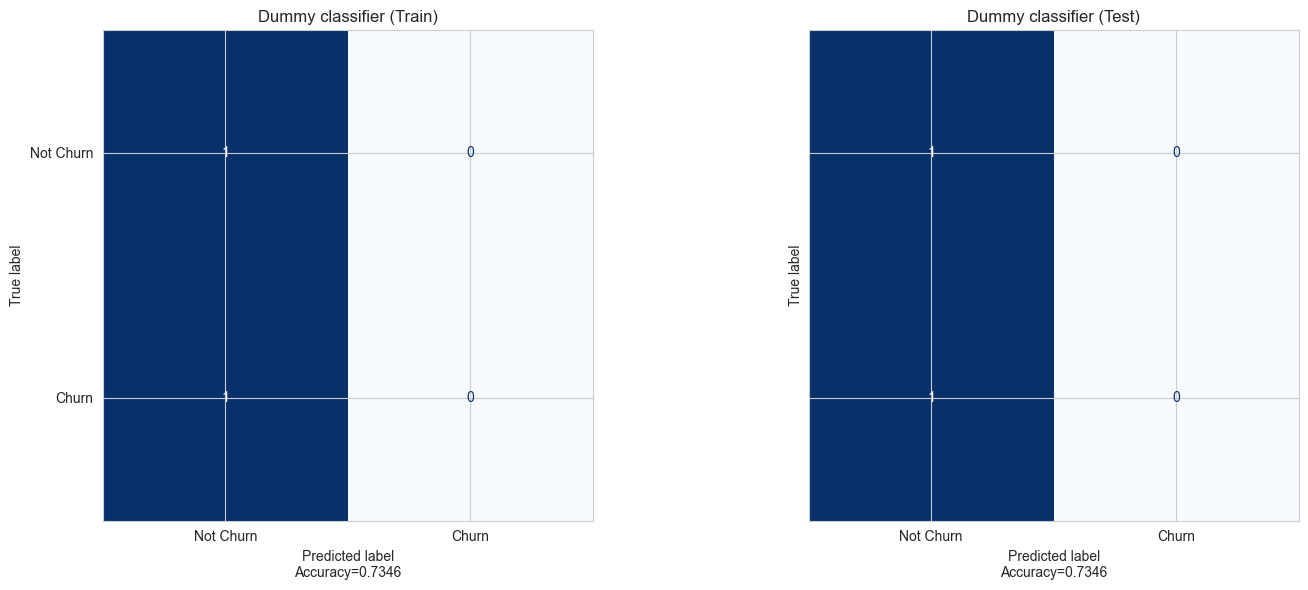

In [21]:
dummy_clf = DummyClassifier(strategy="most_frequent") # dummy classifier with most frequent value strategy
dummy_clf.fit(X_train, y_train)
cf_plot(dummy_clf, X_train, X_test, y_train, y_test, 'Dummy classifier')

Baseline model (menggunakan DummyClassifier dengan most_frequent) menghasilkan akurasi sekitar 73.46% (0.7346). Artinya:
- Baseline model hanya menebak semua data ke kelas yang paling sering muncul (yaitu “tidak churn”).
- Akurasinya 73.46% karena memang mayoritas data termasuk ke kelas itu.

Implikasinya:
Model harus memiliki performa di atas 0.7346.

In [22]:
# List model yang akan digunakan
models = []
models.append(('DT', DecisionTreeClassifier(random_state=42)))
models.append(('SVM', SVC(random_state=42)))

## 4.1 Dataset Asli

----------------RESULTS--------------

Best accuracy in train (CV mean): 0.80
Best accuracy in test: 0.79
Best f1-score in test: 0.55


-------------BEST CONFUSION MATRIX (F1-SCORE TEST)-----------



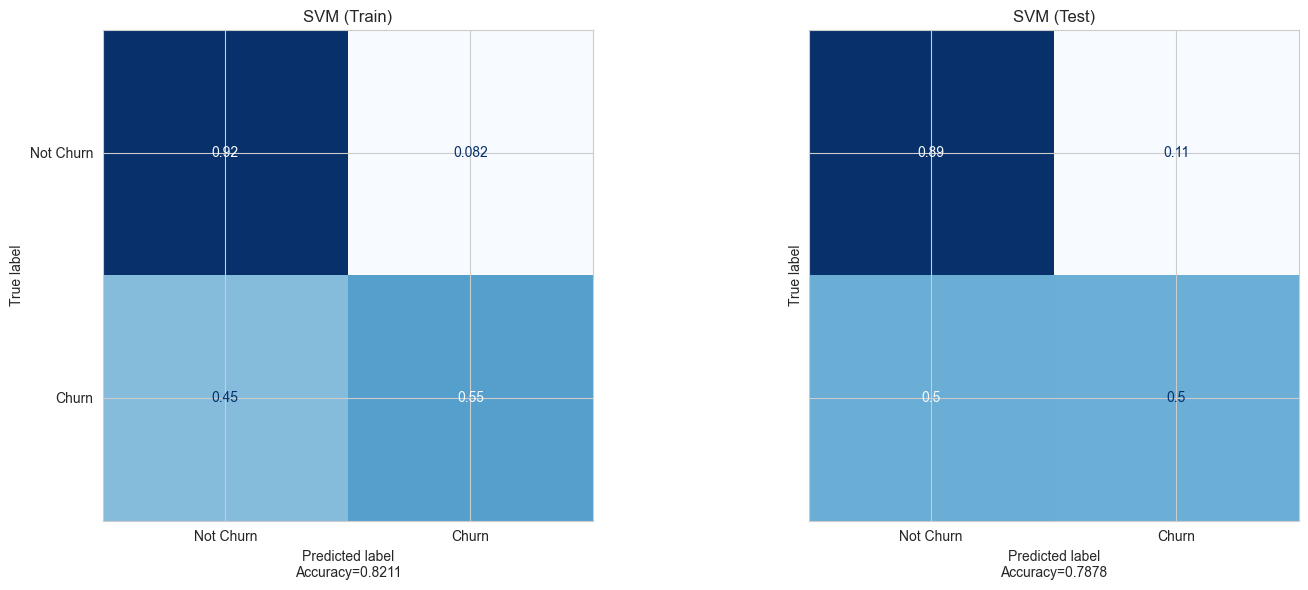

-----------MODELS COMPARISON---------



,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,SVM,Data Asli,0.800140,0.821086,0.787793,0.020947,0.033294,0.553177,0.497326,0.708655,0.626263,0.621337,0.554396,4.203579
1,DT,Data Asli,0.723464,0.998048,0.734564,0.274583,0.263484,0.993311,0.513369,0.999327,0.500000,0.996310,0.506596,0.141597



-------------VIZUALIZATION-----------



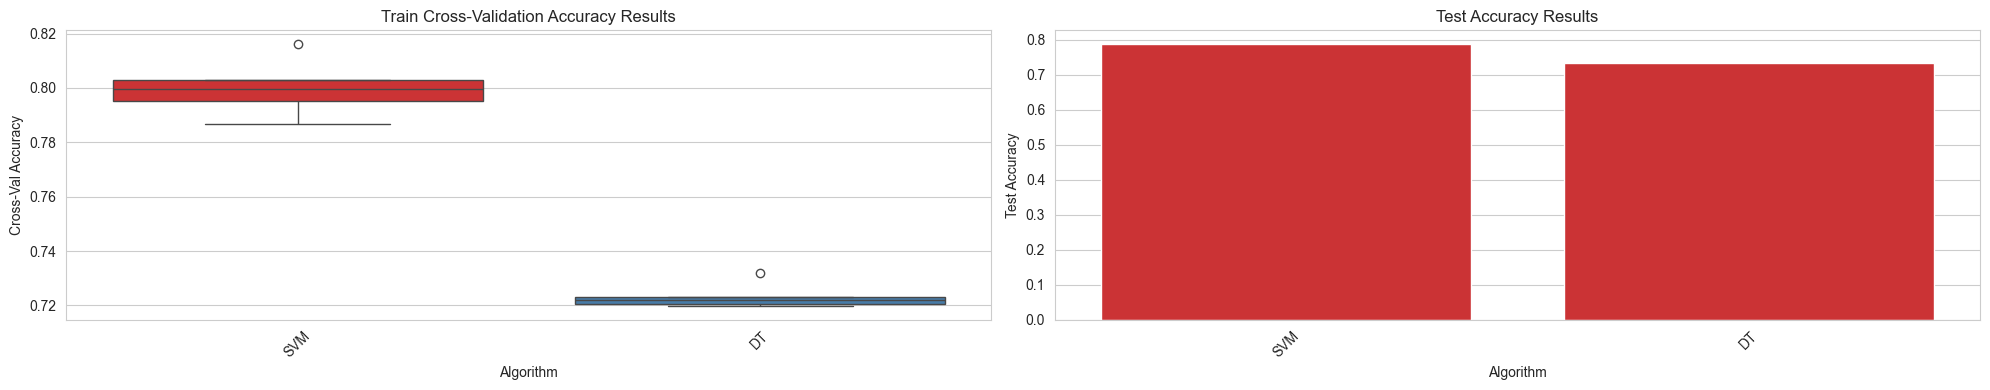

In [23]:
results_cv_df_1, results_df_1 = models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=5, scenario='Data Asli')

## 4.2 SMOTE

Karena data churn unbalanced (lebih banyak jumlah yang Churn = NO) maka akan dilakukan penanganan menggunakan SMOTE.

In [24]:
oversampler= sv.distance_SMOTE() 
X_train_smote, y_train_smote = oversampler.sample(X_train, y_train) 
print("Number transactions X_train dataset: ", X_train_smote.shape)
print("Number transactions y_train dataset: ", y_train_smote.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

2025-06-20 19:32:53,915:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'distance_SMOTE'}")
2025-06-20 19:32:53,919:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-06-20 19:32:53,951:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2025-06-20 19:32:54,930:INFO:distance_SMOTE: simplex sampling with n_dim 2


Number transactions X_train dataset:  (8278, 25)
Number transactions y_train dataset:  (8278,)
Number transactions X_test dataset:  (1409, 25)
Number transactions y_test dataset:  (1409,)


----------------RESULTS--------------

Best accuracy in train (CV mean): 0.84
Best accuracy in test: 0.77
Best f1-score in test: 0.59


-------------BEST CONFUSION MATRIX (F1-SCORE TEST)-----------



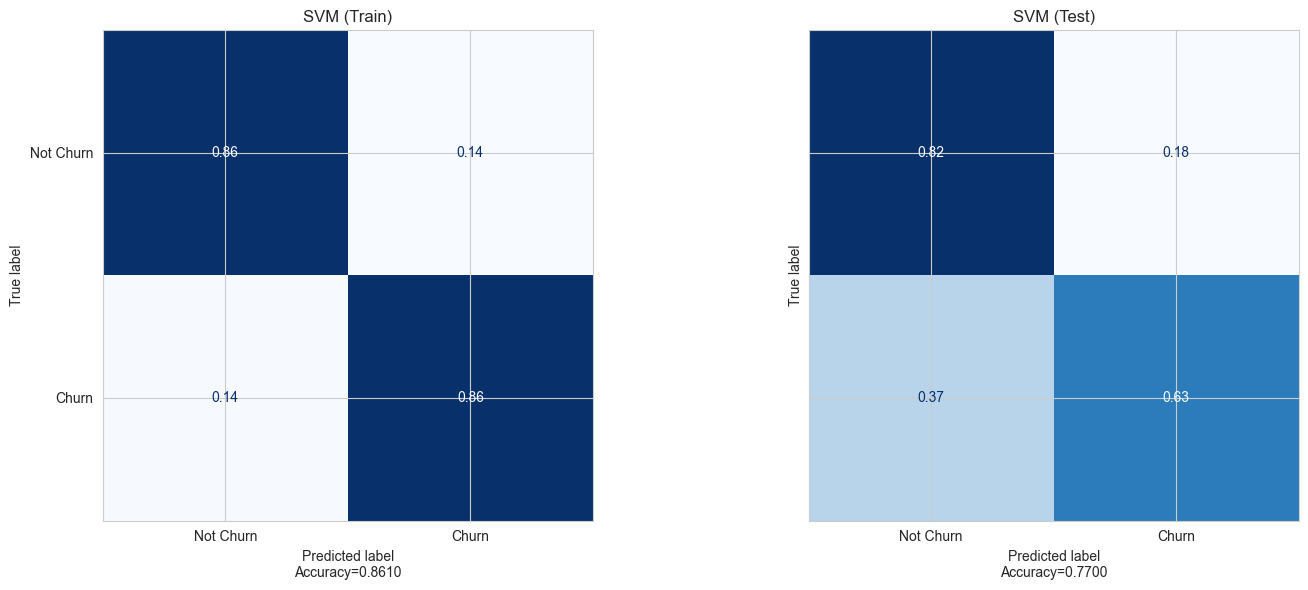

-----------MODELS COMPARISON---------



,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,SVM,SMOTE,0.840542,0.860957,0.770050,0.020415,0.090907,0.859145,0.631016,0.862270,0.559242,0.860704,0.592965,7.485676
1,DT,SMOTE,0.804783,0.998671,0.747339,0.193888,0.251333,0.997584,0.566845,0.999758,0.522167,0.998670,0.543590,0.398756



-------------VIZUALIZATION-----------



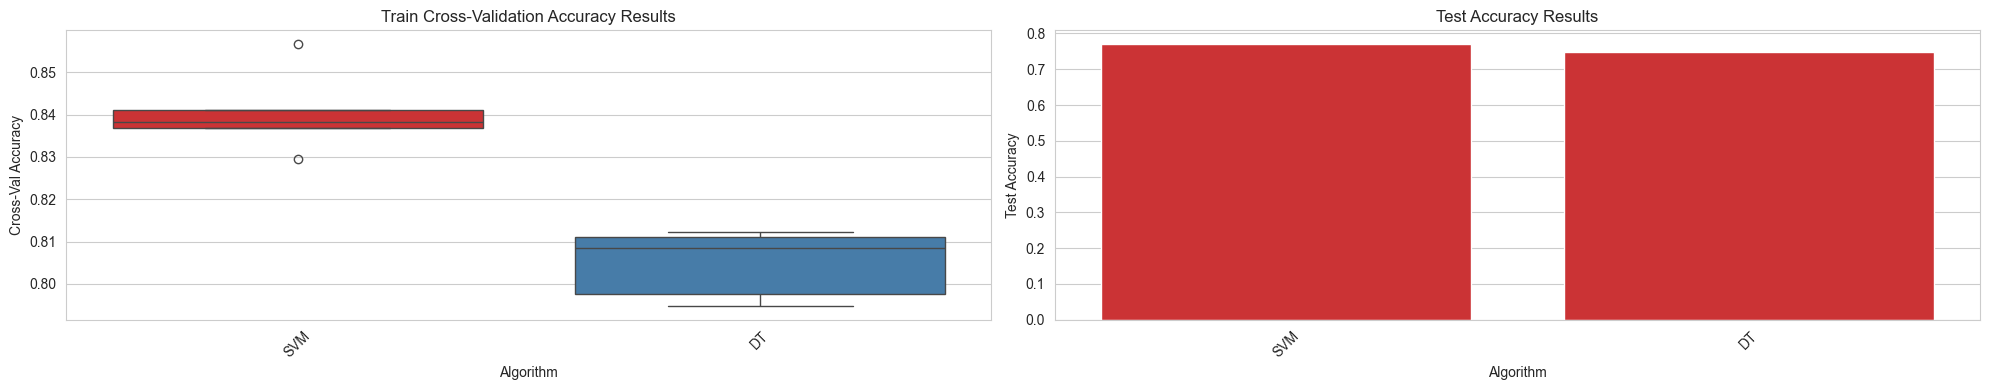

In [25]:
results_cv_df_2, results_df_2 = models_score(models, X_train_smote, y_train_smote, X_test, y_test, scoring = 'accuracy', n_splits=5, scenario='SMOTE')

## 4.3 Random Undersampling

Untuk mengatasi unbalanced data

In [26]:
majority_idx = y_train[y_train == 0].index
minority_idx = y_train[y_train == 1].index

In [27]:
minority_count = y_train[y_train == 1].count()
random_majority_idx = np.random.choice(majority_idx, minority_count, replace=False)

In [28]:
a = y_train.loc[minority_idx]
b = y_train.loc[random_majority_idx]
y_train_under = pd.concat([a, b])
c = X_train_bckp.loc[minority_idx]
d = X_train_bckp.loc[random_majority_idx]
X_train_under = pd.concat([c, d])
y_train_under.value_counts()

Churn
1    1495
0    1495
Name: count, dtype: int64

In [29]:
# normalization
X_train_under = mm_scaler.fit_transform(X_train_under)
X_test_under = mm_scaler.transform(X_test_bckp)
print("Number transactions X_train dataset: ", X_train_under.shape)
print("Number transactions y_train dataset: ", y_train_under.shape)
print("Number transactions X_test dataset: ", X_test_under.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (2990, 25)
Number transactions y_train dataset:  (2990,)
Number transactions X_test dataset:  (1409, 25)
Number transactions y_test dataset:  (1409,)


----------------RESULTS--------------

Best accuracy in train (CV mean): 0.75
Best accuracy in test: 0.74
Best f1-score in test: 0.61


-------------BEST CONFUSION MATRIX (F1-SCORE TEST)-----------



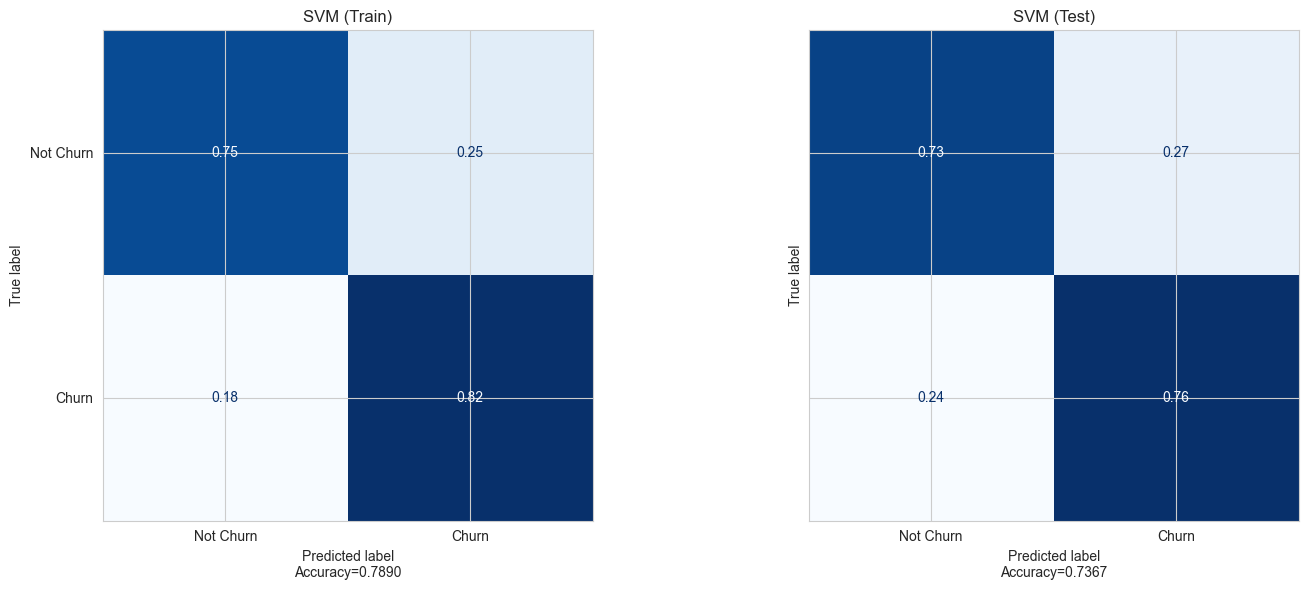

-----------MODELS COMPARISON---------



,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,SVM,Random Undersampling,0.751171,0.788963,0.736693,0.037793,0.052271,0.824080,0.764706,0.77,0.502636,0.796123,0.606575,1.414362
1,DT,Random Undersampling,0.684615,0.999331,0.669269,0.314716,0.330062,0.998662,0.671123,1.00,0.422559,0.999331,0.518595,0.127676



-------------VIZUALIZATION-----------



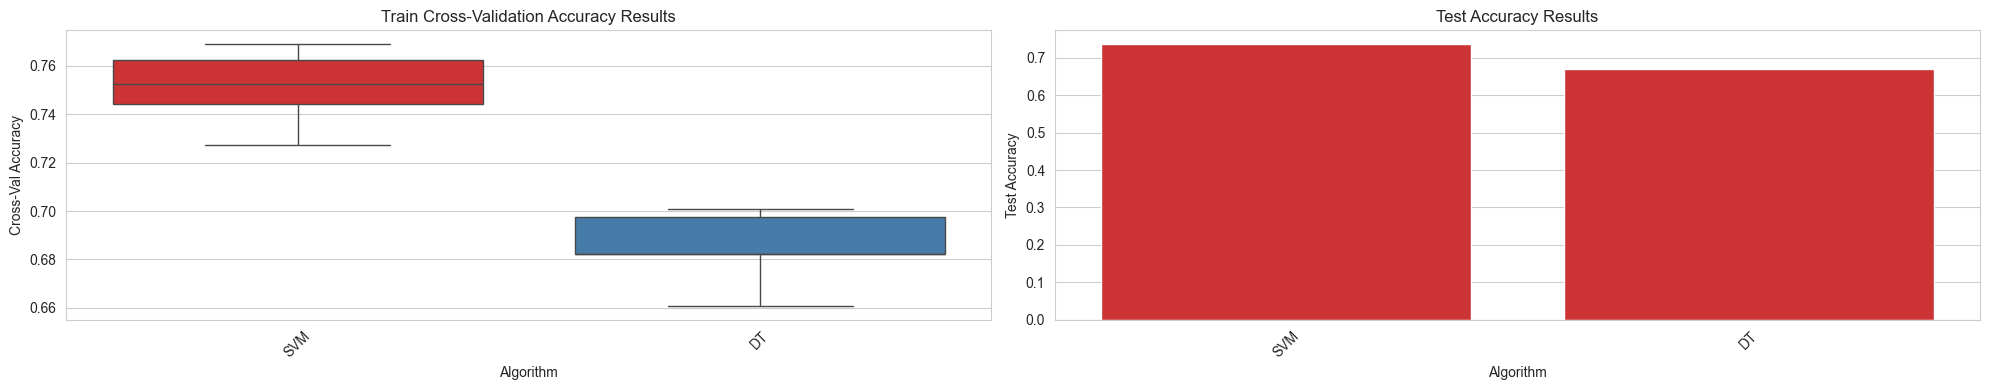

In [30]:
results_cv_df_3, results_df_3 = models_score(models, X_train_under, y_train_under, X_test_under, y_test, scoring = 'accuracy', n_splits=5, scenario = 'Random Undersampling')

## 4.4 Feature Selection

Modeling dengan menggunakan fitur-fitur yang penting saja

In [31]:
# Fungsi untuk memberi warna merah jika nilai negatif
def color_red(val):
    return 'color: red' if val < 0 else 'color: black'

# Tampilkan dataframe dengan bar chart dan warna untuk nilai negatif
outcome_corr = pd.DataFrame(data_pre.corr(method='kendall')['Churn'])
outcome_corr.columns = ['Target variable correlation']
outcome_corr = outcome_corr.sort_values(by='Target variable correlation', ascending=False, key=abs)[1:]
outcome_corr.style.bar(subset=['Target variable correlation'], align='mid', color=['#d65f5f', '#5fba7d']).applymap(color_red).format(precision = 2)

C:\Users\ACER\AppData\Local\Temp\ipykernel_25320\4033563874.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  outcome_corr.style.bar(subset=['Target variable correlation'], align='mid', color=['#d65f5f', '#5fba7d']).applymap(color_red).format(precision = 2)


,Target variable correlation
Contract_Month-to-month,0.41
InternetService_Fiber optic,0.31
tenure,-0.30
Contract_Two year,-0.30
PaymentMethod_Electronic check,0.30
PaperlessBilling,0.19
TotalCharges,-0.19
Contract_One year,-0.18
OnlineSecurity,-0.17
TechSupport,-0.16


### 4.4.1 Hapus fitur korelasi < +- 0.1

In [32]:
# Hapus fitur dengan korelasi < +- 0.1
X = data_pre.drop(['Churn', 'PaymentMethod_Mailed check',
'OnlineBackup',
'DeviceProtection',
'StreamingTV',
'StreamingMovies',
'MultipleLines',
'PhoneService',
'Male'], axis=1)
y = data_pre['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (5634, 17)
Number transactions y_train dataset:  (5634,)
Number transactions X_test dataset:  (1409, 17)
Number transactions y_test dataset:  (1409,)


In [33]:
# normalization
mm_scaler = preprocessing.MinMaxScaler() # scaler
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

----------------RESULTS--------------

Best accuracy in train (CV mean): 0.79
Best accuracy in test: 0.81
Best f1-score in test: 0.58


-------------BEST CONFUSION MATRIX (F1-SCORE TEST)-----------



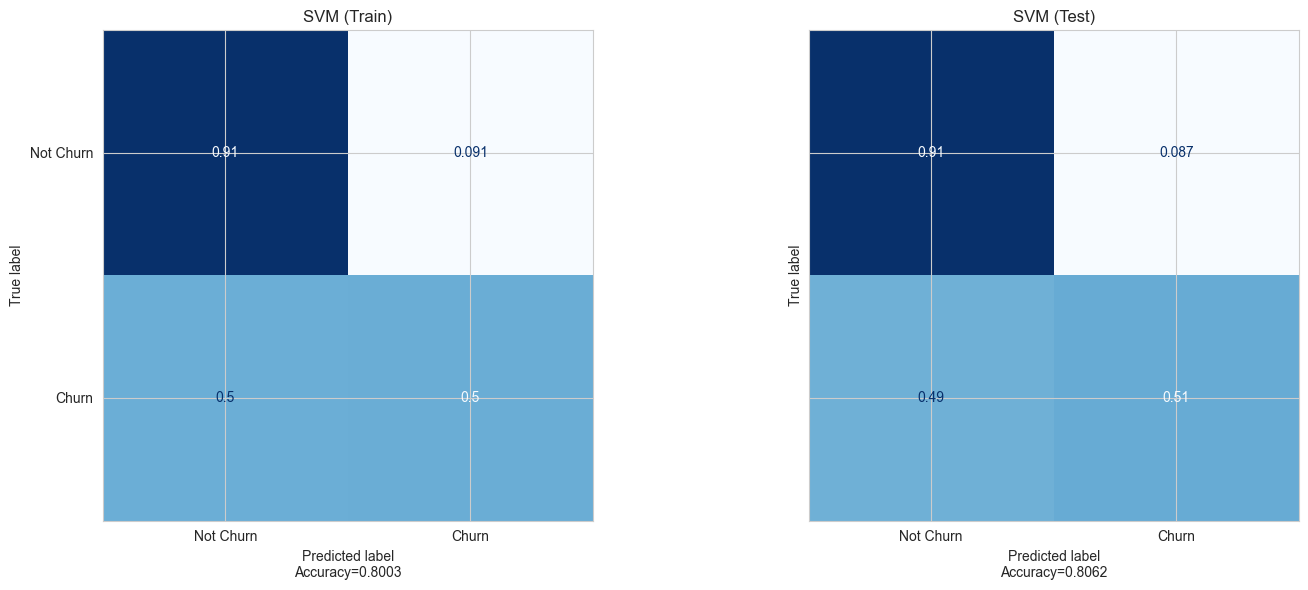

-----------MODELS COMPARISON---------



,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,SVM,Filter <0.1,0.786655,0.800319,0.806246,0.013665,0.005926,0.500668,0.509383,0.664596,0.678571,0.571102,0.581930,4.283716
1,DT,Filter <0.1,0.729679,0.998048,0.733144,0.268369,0.264903,0.995321,0.512064,0.997321,0.496104,0.996320,0.503958,0.128332



-------------VIZUALIZATION-----------



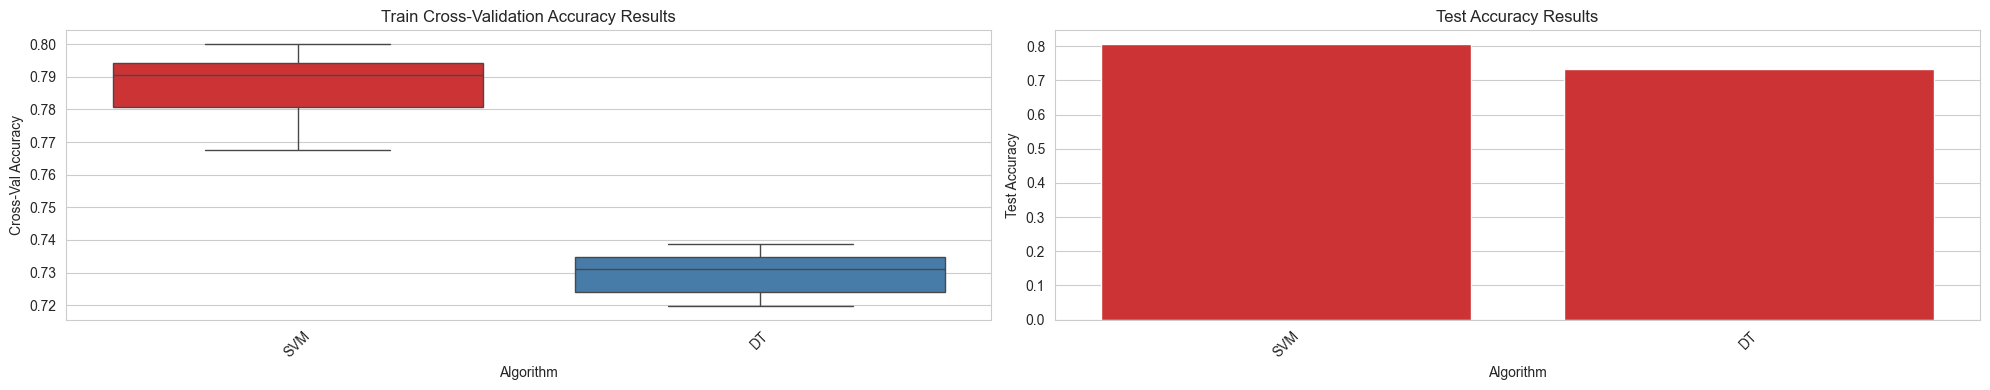

In [34]:
results_cv_df_4, results_df_4 = models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=5, scenario = 'Filter <0.1')

### 4.4.2 Hapus fitur korelasi < +- 0.2

In [35]:
# Hapus fitur dengan korelasi < +- 0.2
X = data_pre[['Contract_Month-to-month',
'InternetService_Fiber optic',
'tenure',
'Contract_Two year',
'PaymentMethod_Electronic check']]
y = data_pre['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (5634, 5)
Number transactions y_train dataset:  (5634,)
Number transactions X_test dataset:  (1409, 5)
Number transactions y_test dataset:  (1409,)


In [36]:
# normalization
mm_scaler = preprocessing.MinMaxScaler() # scaler
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

----------------RESULTS--------------

Best accuracy in train (CV mean): 0.79
Best accuracy in test: 0.81
Best f1-score in test: 0.60


-------------BEST CONFUSION MATRIX (F1-SCORE TEST)-----------



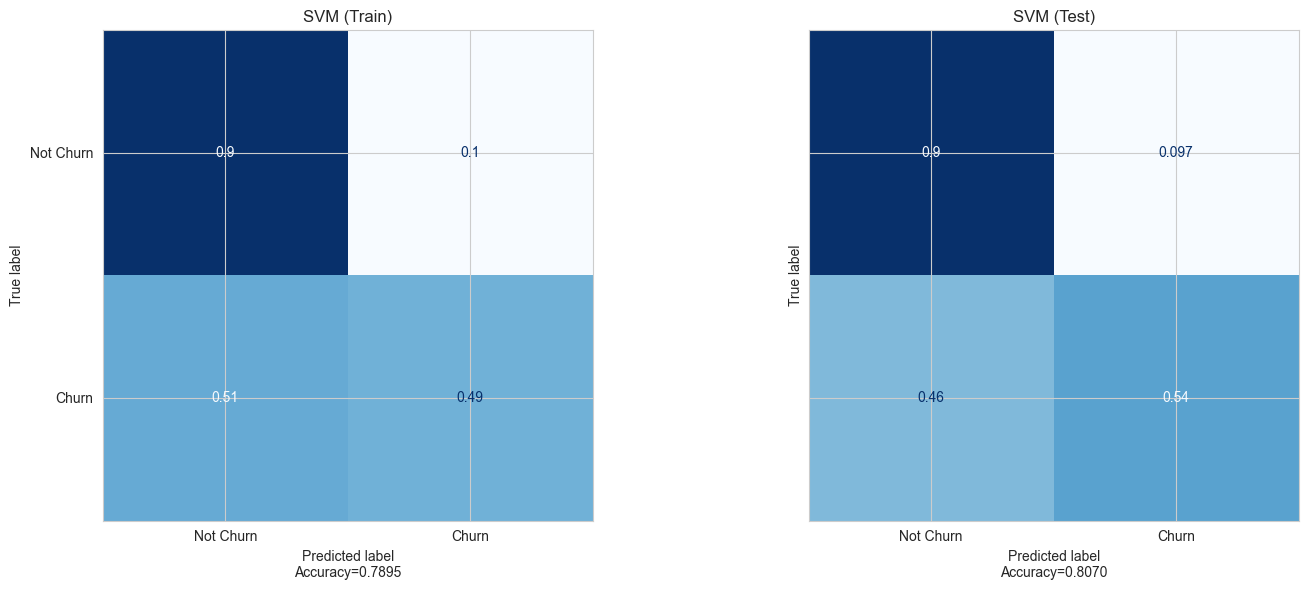

-----------MODELS COMPARISON---------



,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,SVM,Filter <0.2,0.787896,0.789492,0.806955,0.001596,0.017463,0.489973,0.541555,0.634083,0.666667,0.552790,0.597633,3.103166
1,DT,Filter <0.2,0.769261,0.807597,0.792761,0.038336,0.014836,0.542781,0.528150,0.669967,0.629393,0.599705,0.574344,0.014505



-------------VIZUALIZATION-----------



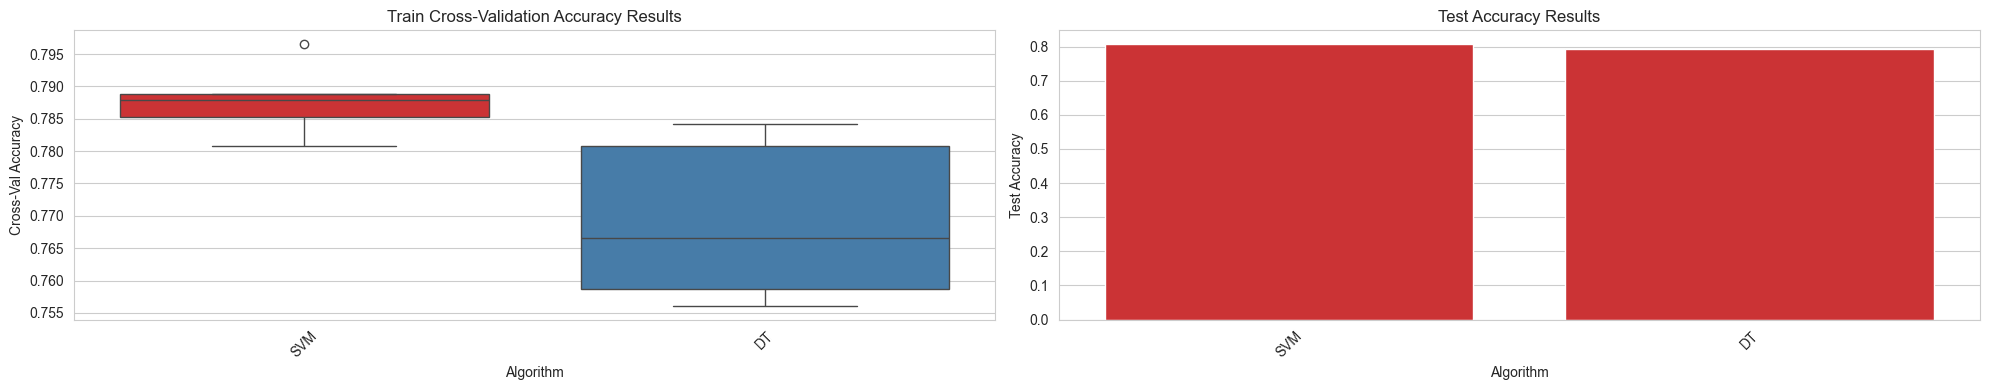

In [37]:
results_cv_df_5, results_df_5 = models_score(models, X_train, y_train, X_test, y_test, scoring = 'accuracy', n_splits=5, scenario='Filter <0.2')

## 4.5 Scenario Terbaik

### 4.5.1 SVM

In [38]:
# Gabungkan semua DataFrame
all_results = pd.concat([results_df_1, results_df_2, results_df_3, 
                         results_df_4, results_df_5],
                        ignore_index=True)

all_svm = all_results[all_results['Name']=='SVM']
all_dt = all_results[all_results['Name']=='DT']


In [39]:
all_svm

,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
0,SVM,Data Asli,0.800140,0.821086,0.787793,0.020947,0.033294,0.553177,0.497326,0.708655,0.626263,0.621337,0.554396,4.203579
2,SVM,SMOTE,0.840542,0.860957,0.770050,0.020415,0.090907,0.859145,0.631016,0.862270,0.559242,0.860704,0.592965,7.485676
4,SVM,Random Undersampling,0.751171,0.788963,0.736693,0.037793,0.052271,0.824080,0.764706,0.770000,0.502636,0.796123,0.606575,1.414362
6,SVM,Filter <0.1,0.786655,0.800319,0.806246,0.013665,0.005926,0.500668,0.509383,0.664596,0.678571,0.571102,0.581930,4.283716
8,SVM,Filter <0.2,0.787896,0.789492,0.806955,0.001596,0.017463,0.489973,0.541555,0.634083,0.666667,0.552790,0.597633,3.103166


In [40]:
# Kolom target
max_cols = ['CV Acc (train)', 'Accuracy (test)', 'F1-score (test)', 'Precision (test)', 'Recall (test)']
min_cols = ['Train/Test Acc Stability']

print("=== Nilai Maksimum dan Skenarionya ===")
for col in max_cols:
    idx = all_svm[col].idxmax()
    value = all_svm.loc[idx, col]
    scenario = all_svm.loc[idx, 'Skenario']
    print(f"{col}: {value:.6f} — Skenario: {scenario}")

print("\n=== Nilai Minimum dan Skenarionya ===")
for col in min_cols:
    idx = all_svm[col].idxmin()
    value = all_svm.loc[idx, col]
    scenario = all_svm.loc[idx, 'Skenario']
    print(f"{col}: {value:.6f} — Skenario: {scenario}")


=== Nilai Maksimum dan Skenarionya ===
CV Acc (train): 0.840542 — Skenario: SMOTE
Accuracy (test): 0.806955 — Skenario: Filter <0.2
F1-score (test): 0.606575 — Skenario: Random Undersampling
Precision (test): 0.678571 — Skenario: Filter <0.1
Recall (test): 0.764706 — Skenario: Random Undersampling

=== Nilai Minimum dan Skenarionya ===
Train/Test Acc Stability: 0.005926 — Skenario: Filter <0.1


Untuk metode SVM skenario terbaiknya adalah: **SMOTE**

### 4.5.2 Decision Tree

In [41]:
all_dt

,Name,Skenario,CV Acc (train),Accuracy (train),Accuracy (test),Train Acc Stability,Train/Test Acc Stability,Recall (train),Recall (test),Precision (train),Precision (test),F1-score (train),F1-score (test),Training time (s)
1,DT,Data Asli,0.723464,0.998048,0.734564,0.274583,0.263484,0.993311,0.513369,0.999327,0.500000,0.996310,0.506596,0.141597
3,DT,SMOTE,0.804783,0.998671,0.747339,0.193888,0.251333,0.997584,0.566845,0.999758,0.522167,0.998670,0.543590,0.398756
5,DT,Random Undersampling,0.684615,0.999331,0.669269,0.314716,0.330062,0.998662,0.671123,1.000000,0.422559,0.999331,0.518595,0.127676
7,DT,Filter <0.1,0.729679,0.998048,0.733144,0.268369,0.264903,0.995321,0.512064,0.997321,0.496104,0.996320,0.503958,0.128332
9,DT,Filter <0.2,0.769261,0.807597,0.792761,0.038336,0.014836,0.542781,0.528150,0.669967,0.629393,0.599705,0.574344,0.014505


In [42]:
# Kolom target
max_cols = ['CV Acc (train)', 'Accuracy (test)', 'F1-score (test)', 'Precision (test)', 'Recall (test)']
min_cols = ['Train Acc Stability', 'Train/Test Acc Stability']

print("=== Nilai Maksimum dan Skenarionya ===")
for col in max_cols:
    idx = all_dt[col].idxmax()
    value = all_dt.loc[idx, col]
    scenario = all_dt.loc[idx, 'Skenario']
    print(f"{col}: {value:.6f} — Skenario: {scenario}")

print("\n=== Nilai Minimum dan Skenarionya ===")
for col in min_cols:
    idx = all_dt[col].idxmin()
    value = all_dt.loc[idx, col]
    scenario = all_dt.loc[idx, 'Skenario']
    print(f"{col}: {value:.6f} — Skenario: {scenario}")


=== Nilai Maksimum dan Skenarionya ===
CV Acc (train): 0.804783 — Skenario: SMOTE
Accuracy (test): 0.792761 — Skenario: Filter <0.2
F1-score (test): 0.574344 — Skenario: Filter <0.2
Precision (test): 0.629393 — Skenario: Filter <0.2
Recall (test): 0.671123 — Skenario: Random Undersampling

=== Nilai Minimum dan Skenarionya ===
Train Acc Stability: 0.038336 — Skenario: Filter <0.2
Train/Test Acc Stability: 0.014836 — Skenario: Filter <0.2


Untuk decision tree skenario terbaiknya adalah : **SMOTE**

# 5. HYPERPARAMETER TUNING
---

## 5.0 Machine learning model optimizer

In [43]:
def optimizer(model, param_dict, seed, X_train, y_train, verbose= 0, n_iter = 10, scoring = 'accuracy', cv = 5):
  random_search = RandomizedSearchCV(model, param_distributions=param_dict, n_iter=n_iter, n_jobs = -1, cv = cv, verbose = verbose, scoring = scoring, random_state=seed)
  random_search.fit(X_train, y_train)
  best_params = random_search.best_params_
  best_score = random_search.best_score_
  print(f'The best found score was:{best_score} \n')
  print(f'The best found params were:{best_params} \n')
  return best_params, best_score

## 5.1 Decision Tree

2025-06-20 22:03:27,116:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'distance_SMOTE'}")
2025-06-20 22:03:27,138:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-06-20 22:03:27,143:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2025-06-20 22:03:27,219:INFO:distance_SMOTE: simplex sampling with n_dim 2


Number transactions X_train dataset:  (8276, 25)
Number transactions y_train dataset:  (8276,)
Number transactions X_test dataset:  (1409, 25)
Number transactions y_test dataset:  (1409,)
Fitting 5 folds for each of 75 candidates, totalling 375 fits
The best found score was:0.8232367879504355 

The best found params were:{'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'} 



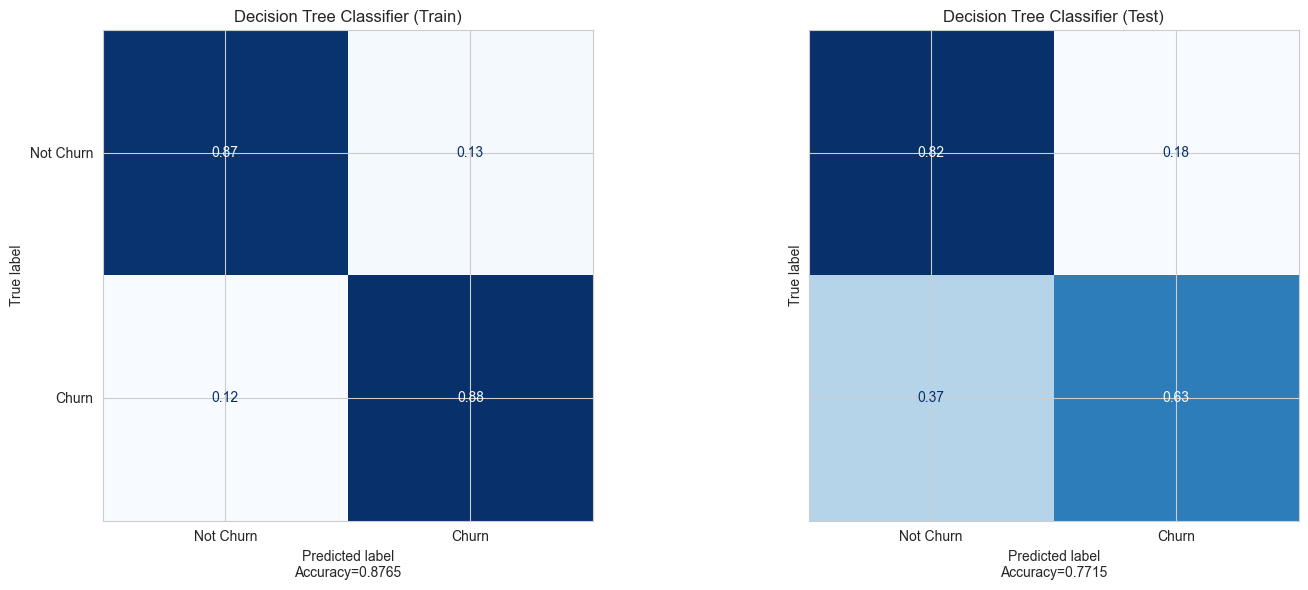

F1-score (test set): 0.5934343434


In [62]:
# 1. Bagi X dan y
X = data_pre.drop('Churn', axis=1)
y = data_pre['Churn']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Normalisasi
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. SMOTE
oversampler= sv.distance_SMOTE() 
X_train_smote, y_train_smote = oversampler.sample(X_train, y_train) 
print("Number transactions X_train dataset: ", X_train_smote.shape)
print("Number transactions y_train dataset: ", y_train_smote.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

# Parameter untuk Decision Tree
param_dict_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Inisialisasi model dan optimasi
dt_clf = DecisionTreeClassifier(random_state=seed)
best_params_dt, best_score_dt = optimizer(dt_clf, param_dict_dt, seed, X_train_smote, y_train_smote, verbose=1, n_iter=75, scoring='accuracy')

# Fit model terbaik
dt_clf = DecisionTreeClassifier(random_state=seed, **best_params_dt)
dt_clf.fit(X_train_smote, y_train_smote)

# Plot hasil
cf_plot(dt_clf, X_train_smote, X_test, y_train_smote, y_test, 'Decision Tree Classifier')
# Hitung F1-score
y_pred = dt_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score (test set):", round(f1, 10))

Important features

In [ ]:
print('Menurut model Decision Tree, fitur yang paling penting adalah: \n')

# Ambil feature importance
d = {'Feature': X.columns, 'Importance': dt_clf.feature_importances_}
df_explic = pd.DataFrame(d, columns=['Feature', 'Importance'])
s
# Tambahkan arah pengaruh hanya jika relevan (tidak selalu bisa diinterpretasi di Decision Tree)
df_explic['Importance'] = np.abs(df_explic['Importance'])  # optional, sudah positif
df_explic = df_explic.sort_values(by='Importance', ascending=False)
df_explic

Menurut model Decision Tree, fitur yang paling penting adalah: 



,Feature,Importance
18,Contract_Month-to-month,0.366681
12,PaperlessBilling,0.142545
13,MonthlyCharges,0.097724
3,tenure,0.056282
23,PaymentMethod_Electronic check,0.052010
6,OnlineSecurity,0.048904
9,TechSupport,0.038958
14,TotalCharges,0.034012
11,StreamingMovies,0.029272
2,Dependents,0.018797


In [64]:
# Visualisasi sebagai teks
from sklearn.tree import DecisionTreeClassifier, export_text
tree_rules = export_text(dt_clf, feature_names=list(X.columns))
print(tree_rules)

|--- Contract_Month-to-month <= 0.00
|   |--- MonthlyCharges <= 0.75
|   |   |--- Contract_Two year <= 0.90
|   |   |   |--- StreamingMovies <= 0.05
|   |   |   |   |--- PaymentMethod_Electronic check <= 0.50
|   |   |   |   |   |--- tenure <= 0.81
|   |   |   |   |   |   |--- MonthlyCharges <= 0.42
|   |   |   |   |   |   |   |--- TotalCharges <= 0.00
|   |   |   |   |   |   |   |   |--- tenure <= 0.02
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- tenure >  0.02
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- TotalCharges >  0.00
|   |   |   |   |   |   |   |   |--- OnlineSecurity <= 0.50
|   |   |   |   |   |   |   |   |   |--- MonthlyCharges <= 0.03
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- MonthlyCharges >  0.03
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- OnlineSecurity >  0.50
|   |   |   |   |   |   |   |  

In [65]:
with open("C:/Users/ACER/OneDrive/Kuliah/SEM 8/Komputasi Statistika II/Project UAS/Hasil DT.txt", "w") as f:
    f.write(tree_rules)

## 5.2 SVM

### 5.2.1 SMOTE

2025-06-20 21:04:36,886:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'distance_SMOTE'}")


2025-06-20 21:04:36,888:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-06-20 21:04:36,893:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2025-06-20 21:04:37,003:INFO:distance_SMOTE: simplex sampling with n_dim 2


Number transactions X_train dataset:  (8276, 25)
Number transactions y_train dataset:  (8276,)
Number transactions X_test dataset:  (1409, 25)
Number transactions y_test dataset:  (1409,)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best found score was:0.826381554942569 

The best found params were:{'kernel': 'rbf', 'gamma': 'auto', 'C': 100} 



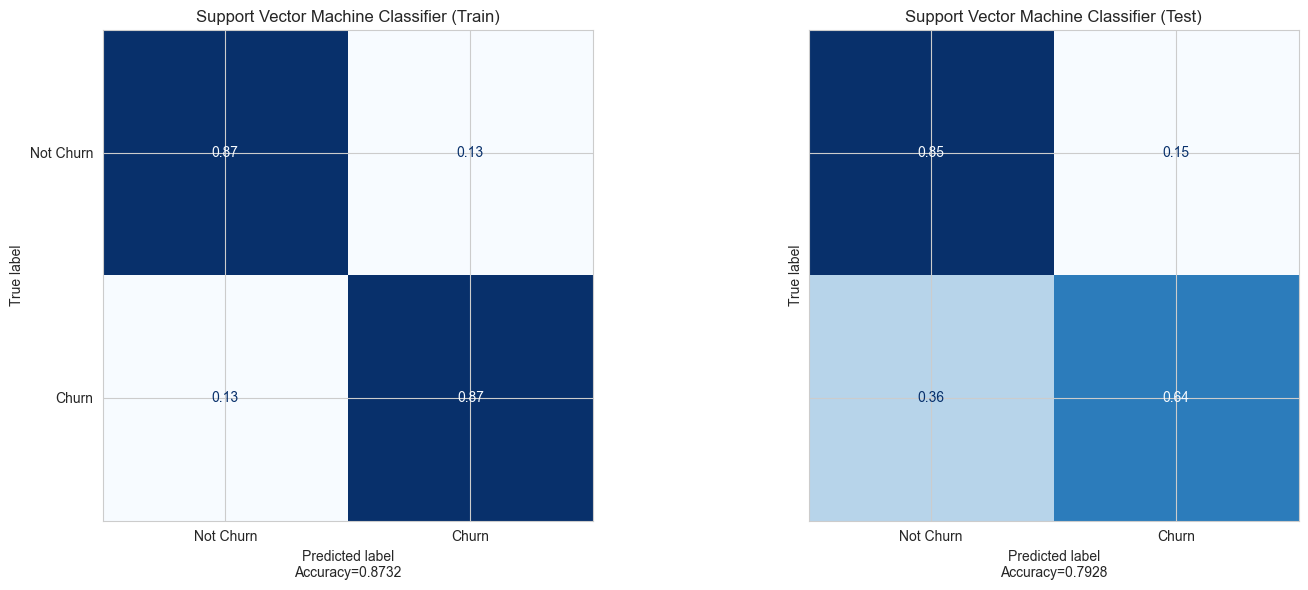

F1-score (test): 0.621761658


In [59]:
# 1. Bagi X dan y
X = data_pre.drop(['Churn'], axis=1)
y = data_pre['Churn']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# 3. Normalisasi
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 4. SMOTE
oversampler= sv.distance_SMOTE() 
X_train_smote, y_train_smote = oversampler.sample(X_train, y_train) 
print("Number transactions X_train dataset: ", X_train_smote.shape)
print("Number transactions y_train dataset: ", y_train_smote.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

# 5. Hyperparameter tuning dengan optimizer
param_dict_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svc_clf = SVC(random_state=seed)
best_params_svc, best_score_svc = optimizer(svc_clf, param_dict_svc, seed, X_train_smote, 
                                            y_train_smote, verbose=1, n_iter=30, scoring='accuracy')

# 6. Latih model dengan best params
svc_clf = SVC(random_state=seed, **best_params_svc)
svc_clf.fit(X_train_smote, y_train_smote)

# 7. Confusion matrix & evaluasi
cf_plot(svc_clf, X_train_smote, X_test, y_train_smote, y_test, 'Support Vector Machine Classifier')

# Hitung F1-score
y_pred = svc_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score (test):", round(f1, 10))

### 5.2.2 Random Undersampling

Fitting 5 folds for each of 30 candidates, totalling 150 fits
The best found score was:0.7486546697115035 

The best found params were:{'kernel': 'poly', 'gamma': 'auto', 'C': 10} 



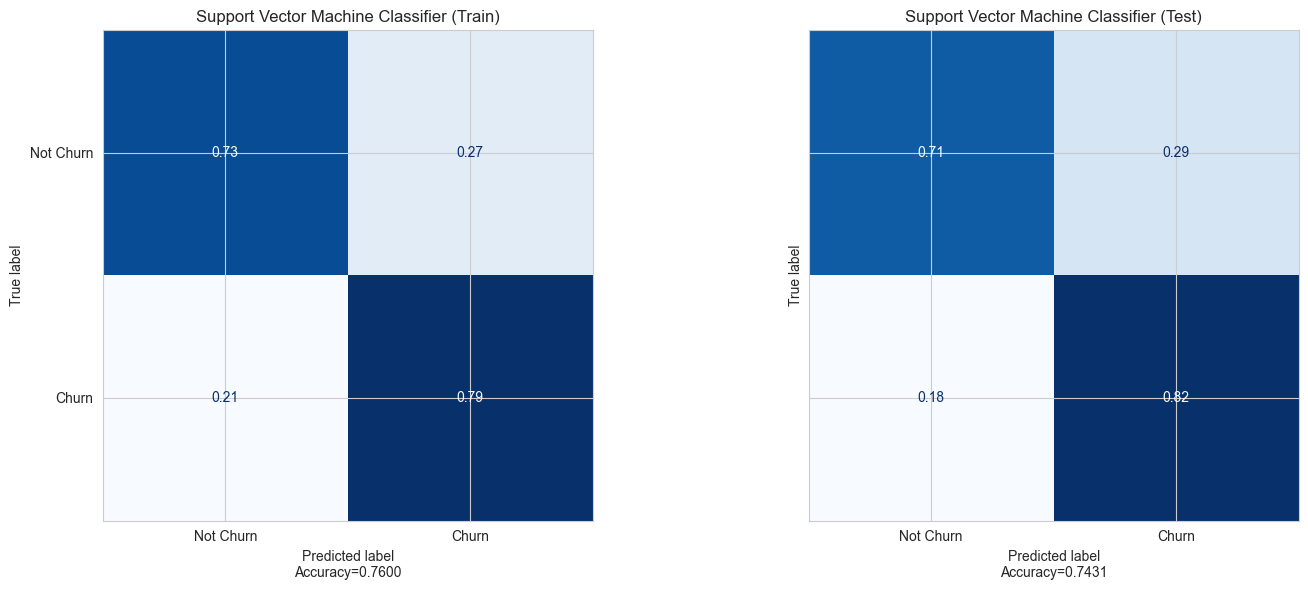

F1-score (test set): 0.6290983607


In [60]:
# 1. Bagi X dan y
X = data_pre.drop(['Churn'], axis=1)
y = data_pre['Churn']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# 3. Random Undersampling
majority_idx = y_train[y_train == 0].index
minority_idx = y_train[y_train == 1].index
minority_count = y_train[y_train == 1].count()
random_majority_idx = np.random.choice(majority_idx, minority_count, replace=False)

a = y_train.loc[minority_idx]
b = y_train.loc[random_majority_idx]
y_train_under = pd.concat([a, b])

c = X_train.copy().loc[minority_idx]
d = X_train.copy().loc[random_majority_idx]
X_train_under = pd.concat([c, d])
y_train_under.value_counts()

# 4. Normalisasi
X_train_under = mm_scaler.fit_transform(X_train_under)
X_test_under = mm_scaler.transform(X_test.copy())

# 5. Hyperparameter tuning dengan optimizer
param_dict_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

svc_clf_ru = SVC(random_state=seed)
best_params_svc, best_score_svc = optimizer(svc_clf_ru, param_dict_svc, seed, X_train_under, 
                                            y_train_under, verbose=1, n_iter=30, scoring='accuracy')

# 6. Latih model dengan best params
svc_clf_ru = SVC(random_state=seed, **best_params_svc)
svc_clf_ru.fit(X_train_under, y_train_under)

# 7. Confusion matrix & evaluasi
cf_plot(svc_clf_ru, X_train_under, X_test_under, y_train_under, y_test, 'Support Vector Machine Classifier')

# Hitung F1-score
y_pred = svc_clf_ru.predict(X_test_under)
f1 = f1_score(y_test, y_pred)
print("F1-score (test set):", round(f1, 10))

Important Features

In [49]:
result = permutation_importance(svc_clf, X_test, y_test, n_repeats=10, random_state=seed, scoring='accuracy')

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
24,PaymentMethod_Mailed check,9.134138e-02
22,PaymentMethod_Credit card (automatic),8.942512e-02
21,PaymentMethod_Bank transfer (automatic),8.878637e-02
23,PaymentMethod_Electronic check,4.570617e-02
17,InternetService_Fiber optic,4.322214e-02
19,Contract_One year,3.946061e-02
20,Contract_Two year,3.342796e-02
3,tenure,2.973740e-02
18,Contract_Month-to-month,1.816891e-02
14,TotalCharges,1.135557e-02
